In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [2]:
def measure_click(ctr):
    return 1 if np.random.uniform(0, 1) < ctr else 0


def measure_a():
    return measure_click(ctr=0.005)


def measure_b():
    return measure_click(ctr=0.007)

In [3]:
def design_ab_test():
    def pilot_study(num_pilot_measurements):
        clicked_pre_a = np.array([measure_a() for _ in range(num_pilot_measurements)])
        clicked_pre_b = np.array([measure_b() for _ in range(num_pilot_measurements)])
        sd1 = np.sqrt(clicked_pre_a.std() ** 2 + clicked_pre_b.std() ** 2)
        return sd1

    sd1 = pilot_study(1000)
    prac_sig = 0.001  # Difference in mean
    num_ind = (2.48 * sd1 / prac_sig) ** 2
    return int(num_ind)

In [4]:
np.random.seed(17)
num_ind = design_ab_test()
num_ind

91561

In [5]:
def run_ab_test(num_ind):
    clicked_a = []
    clicked_b = []
    for n in range(num_ind):
        # Randomize between A and B
        if np.random.uniform(0, 1) < 0.5:
            clicked = measure_a()
            clicked_a.append(clicked)
        else:
            clicked = measure_b()
            clicked_b.append(clicked)

    clicked_a = np.array(clicked_a)
    clicked_b = np.array(clicked_b)

    return clicked_a, clicked_b

In [6]:
def analyze_ab_test(clicked_a, clicked_b, num_ind):
    mean_a = clicked_a.mean()
    mean_b = clicked_b.mean()
    std_a = clicked_a.std()
    std_b = clicked_b.std()

    m = mean_b - mean_a
    se = np.sqrt((std_a**2 + std_b**2) / num_ind)
    z = m / se
    return z

In [7]:
np.random.seed(17)
num_ind = design_ab_test()
clicked_a, clicked_b = run_ab_test(num_ind)
z = analyze_ab_test(clicked_a, clicked_b, num_ind)
num_ind, z

(91561, 2.954555022088617)

In [8]:
# Positive z indicates a right-tailed test, so larger.
# 0.0015 < 0.05, statistically significant
st.norm.sf(np.abs(z))

0.0015656015654818142

In [9]:
def ab_test(num_ind):
    sum_clicks = 0.0
    num_ads = 0.0
    sum_a = 0.0
    num_a = 0
    sum_b = 0.0
    num_b = 0

    ctr_vs_n = []
    ctr_a = []
    ctr_b = []
    for n in range(num_ind):
        if np.random.uniform(0, 1) < 0.5:
            clicked = measure_a()
            sum_a += clicked
            num_a += 1
        else:
            clicked = measure_b()
            sum_b += clicked
            num_b += 1
        sum_clicks += clicked
        num_ads += 1
        if num_a > 0 and num_b > 0:
            ctr_a.append(sum_a / num_a)
            ctr_b.append(sum_b / num_b)
            ctr_vs_n.append(sum_clicks / num_ads)

    return ctr_vs_n, ctr_a, ctr_b

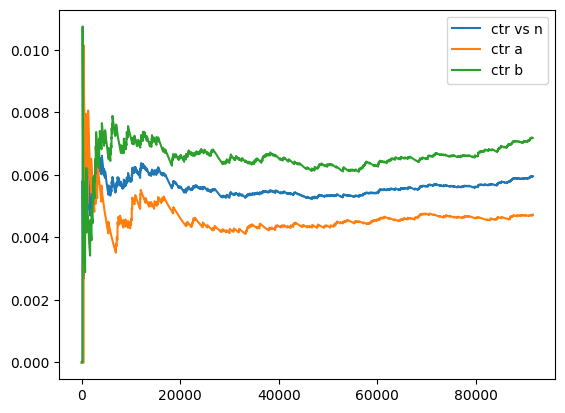

In [10]:
ctr_vs_n, ctr_a, ctr_b = ab_test(num_ind)
plt.plot(ctr_vs_n, label="ctr vs n")
plt.plot(ctr_a, label="ctr a")
plt.plot(ctr_b, label="ctr b")
plt.legend();

In [11]:
def epsilon_greedy(num_ind, epsilon):
    sum_clicks = 0.0
    num_ads = 0.0
    sum_a = 0.0
    num_a = 0
    sum_b = 0.0
    num_b = 0
    used_b = []

    ctr_vs_n = []
    ctr_a = []
    ctr_b = []
    for n in range(num_ind):
        select = None
        # Exploit: choose the best arm.
        if np.random.uniform(0, 1) < 1 - epsilon:
            ctr_a = sum_a / num_a if num_a > 0 else 0
            ctr_b = sum_b / num_b if num_b > 0 else 0
            if ctr_a > ctr_b:
                select = "A"
            else:
                select = "B"
        # Explore.
        else:
            if np.random.uniform(0, 1) < 0.5:
                select = "A"
            else:
                select = "B"
        if select == "A":
            clicked = measure_a()
            sum_a += clicked
            num_a += 1
            used_b.append(False)
        else:
            clicked = measure_b()
            sum_b += clicked
            num_b += 1
            used_b.append(True)
        sum_clicks += clicked
        num_ads += 1
        ctr_vs_n.append(sum_clicks / num_ads)

    return ctr_vs_n, used_b

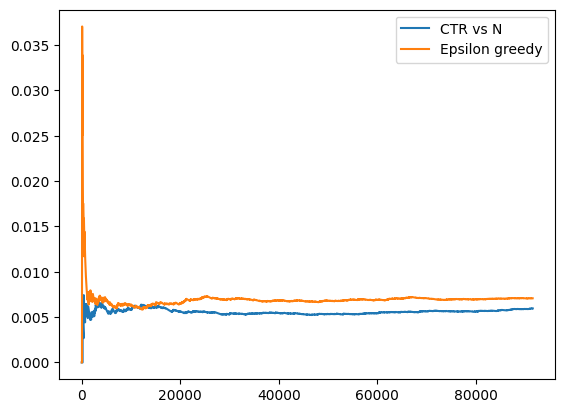

In [12]:
ctr_vs_n_greedy, used_b = epsilon_greedy(num_ind, epsilon=0.1)
plt.plot(ctr_vs_n, label="CTR vs N")
plt.plot(ctr_vs_n_greedy, label="Epsilon greedy")
plt.legend();

In [13]:
np.sum(used_b) / len(used_b)

0.9496073655814157

In [14]:
def epsilon_greedy_decay():
    bm_max = 0.01  # Business metrics max
    prac_sig = 0.001
    c = 5

    epsilon_0 = 2 * c * (bm_max / prac_sig) ** 2
    epsilon_stop = 0.01

    sum_clicks = 0.0
    num_ads = 0.0
    sum_a = 0.0
    num_a = 0
    sum_b = 0.0
    num_b = 0
    ctr_vs_n = []
    epsilons = []

    n = 0
    selected = None
    while True:
        epsilon = min(1.0, epsilon_0 / (1.0 + n))
        epsilons.append(epsilon)
        if epsilon < epsilon_stop:
            break
        select = None
        # Explore: randomly choose an arm
        p = [0.5, 0.5]

        # Exploit: choose the best arm.
        if np.random.uniform(0, 1) < 1 - epsilon:
            ctr_a = sum_a / num_a if num_a > 0 else 0
            ctr_b = sum_b / num_b if num_b > 0 else 0
            p = [ctr_a, ctr_b]
        select = np.random.choice(["A", "B"], p=p / np.sum(p))
        if select == "A":
            selected = "A"
            clicked = measure_a()
            sum_a += clicked
            num_a += 1
        else:
            selected = "B"
            clicked = measure_b()
            sum_b += clicked
            num_b += 1
        sum_clicks += clicked
        num_ads += 1
        ctr_vs_n.append(sum_clicks / num_ads)
        n += 1
    return ctr_vs_n, epsilons, selected

'B'

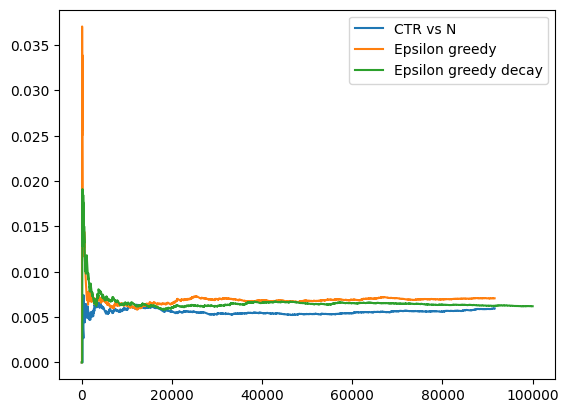

In [15]:
ctr_vs_n_greedy_decay, epsilons, selected = epsilon_greedy_decay()
plt.plot(ctr_vs_n, label="CTR vs N")
plt.plot(ctr_vs_n_greedy, label="Epsilon greedy")
plt.plot(ctr_vs_n_greedy_decay, label="Epsilon greedy decay")
plt.legend()
selected

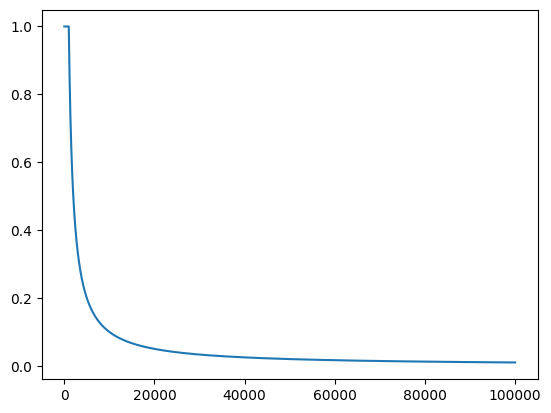

In [16]:
plt.plot(epsilons);

## Epsilon-greedy with four arms

In [17]:
def measure_arm(i_arm):
    return measure_click(ctr=0.005 + i_arm * 0.002)


def epsilon_greedy_decay_multi():
    bm_max = 0.01
    prac_sig = 0.001
    k = 4
    c = 5

    epsilon_0 = k * c * (bm_max / prac_sig) ** 2
    epsilon_stop = 0.01

    sum_clicks = 0.0
    num_ads = 0.0
    sum_arm = [0.0] * k
    num_arm = [0.0] * k
    ctr_vs_n = []

    n = 0
    arms_selected = []
    while True:
        epsilon = min(1.0, epsilon_0 / (1.0 + n))
        if epsilon < epsilon_stop:
            break
        i_selected = None
        if np.random.uniform(0, 1) < 1 - epsilon:
            # Break ties by randomly adding a tiny 0 value.
            i_selected = np.argmax(
                [
                    (
                        sum_arm[i] / num_arm[i]
                        if num_arm[i] > 0
                        else np.random.normal() * 1e-9
                    )
                    for i in range(k)
                ]
            )
        else:
            i_selected = np.random.randint(k)
        arms_selected.append(i_selected)
        clicked = measure_arm(i_selected)
        sum_arm[i_selected] += clicked
        num_arm[i_selected] += 1
        sum_clicks += clicked
        num_ads += 1
        ctr_vs_n.append(sum_clicks / num_ads)

        n += 1

    return ctr_vs_n, arms_selected

In [18]:
[0.005 + i * 0.002 for i in range(4)]

[0.005, 0.007, 0.009000000000000001, 0.011]

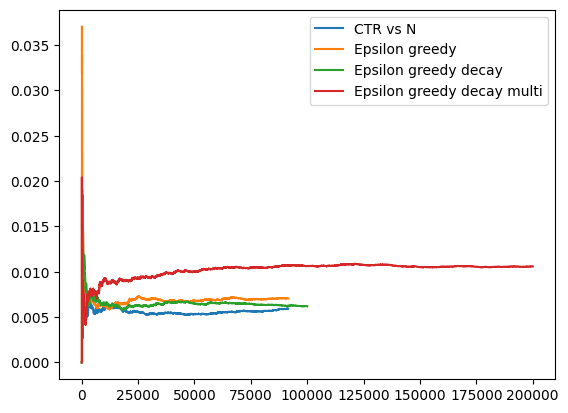

In [19]:
ctr_vs_n_greedy_decay_multi, arms_selected = epsilon_greedy_decay_multi()
plt.plot(ctr_vs_n, label="CTR vs N")
plt.plot(ctr_vs_n_greedy, label="Epsilon greedy")
plt.plot(ctr_vs_n_greedy_decay, label="Epsilon greedy decay")
plt.plot(ctr_vs_n_greedy_decay_multi, label="Epsilon greedy decay multi")
plt.legend();

In [20]:
from collections import Counter

for k, v in Counter(arms_selected).most_common():
    print(
        "arm={}, percent={:0.2f}%, selected={}".format(
            k, v / len(arms_selected) * 100, v
        )
    )

arm=3, percent=95.21%, selected=190422
arm=1, percent=1.96%, selected=3927
arm=2, percent=1.42%, selected=2843
arm=0, percent=1.40%, selected=2808


## Thompson Sampling

In [21]:
def boostrap_sample(data):
    n = len(data)
    return data[np.random.randint(n, size=(n,))]

In [22]:
I_clicked = np.array([0, 0, 1, 0, 1, 1, 0, 0, 1, 0])
CTR = I_clicked.mean()
print(CTR)

0.4


In [23]:
np.random.seed(17)
print(boostrap_sample(I_clicked))
print(boostrap_sample(I_clicked))
print(boostrap_sample(I_clicked))

[0 0 0 0 0 0 1 0 1 0]
[0 0 0 1 1 0 0 0 0 0]
[0 1 0 0 1 0 0 1 0 0]


In [24]:
np.random.seed(17)
I_clicked_1 = np.array([measure_click(ctr=0.005) for _ in range(10000)])
I_clicked_2 = np.array([measure_click(ctr=0.007) for _ in range(10000)])
print(I_clicked_1.mean(), I_clicked_2.mean())

0.0042 0.0057


In [25]:
def estimate_pbest(I_clicked_1, I_clicked_2):
    counts = [0, 0]
    num_samples = 100
    for _ in range(num_samples):
        ctr_1 = boostrap_sample(I_clicked_1).mean()
        ctr_2 = boostrap_sample(I_clicked_2).mean()
        if ctr_1 > ctr_2:
            counts[0] += 1
        elif ctr_2 > ctr_1:
            counts[1] += 1
        else:
            pass

    p_best = np.array(counts) / num_samples
    return p_best

In [26]:
estimate_pbest(I_clicked_1, I_clicked_2)

array([0.09, 0.88])

In [27]:
def estimate_pbest(I_clickeds):
    counts = [0] * len(I_clickeds)
    num_samples = 100
    for _ in range(num_samples):
        ctrs = [boostrap_sample(I_clicked).mean() for I_clicked in I_clickeds]
        ctrs = np.array(ctrs)
        i = np.where(ctrs == ctrs.max())[0]
        if len(i) == 1:
            counts[i[0]] += 1

    return np.array(counts) / num_samples

In [28]:
np.random.seed(17)
I_clickeds = [None] * 4
I_clickeds[0] = np.array([measure_click(ctr=0.003) for _ in range(10000)])
I_clickeds[1] = np.array([measure_click(ctr=0.005) for _ in range(10000)])
I_clickeds[2] = np.array([measure_click(ctr=0.007) for _ in range(10000)])
I_clickeds[3] = np.array([measure_click(ctr=0.009) for _ in range(10000)])
estimate_pbest(I_clickeds)

array([0.  , 0.  , 0.04, 0.94])

In [29]:
# Randomized probability matching
def rpm_select_arm(I_clickeds):
    ctrs = [boostrap_sample(I_clicked).mean() for I_clicked in I_clickeds]
    ctrs = np.array(ctrs)
    i = np.where(ctrs == ctrs.max())[0]
    if len(i) != 1:
        return np.random.randint(len(I_clickeds))
    return i[0]

In [30]:
class OnlineBootstrap:
    def __init__(self, num_bs_means):
        self._sums = np.zeros(shape=(num_bs_means,))
        self._n = np.zeros(shape=(num_bs_means,))
        self._count = 0

    def append(self, clicked):
        i = np.where(
            np.random.randint(
                2,
                size=(
                    len(
                        self._n,
                    )
                ),
            )
            == 0
        )[0]
        self._sums[i] += clicked
        self._n[i] += 1
        self._count += 1

    def CTR_estimate(self):
        i = np.random.randint(len(self._n))
        if self._n[i] == 0:
            return np.inf
        return self._sums[i] / self._n[i]

    def count(self):
        return self._count

In [31]:
def rpm_select_arm_ob(obs):
    ctrs = [ob.CTR_estimate() for ob in obs]
    ctrs = np.array(ctrs)
    i = np.where(ctrs == ctrs.max())[0]
    return np.random.choice(i)

In [32]:
def estimate_pbest_ob(obs):
    counts = [0] * len(obs)
    num_samples = 100
    for _ in range(num_samples):
        ctrs = [ob.CTR_estimate() for ob in obs]
        ctrs = np.array(ctrs)
        i = np.where(ctrs == ctrs.max())[0]
        if len(i) == 1:
            counts[i[0]] += 1
    return np.array(counts) / num_samples

In [33]:
def thompson_sampling():
    k = 4
    num_bs_means = 100
    p_stop = 0.95
    smallest_sum_difference = 1
    prac_sig = 0.001

    min_samples_per_arm = smallest_sum_difference / prac_sig
    obs = [OnlineBootstrap(num_bs_means) for _ in range(k)]
    sum_clicks = 0.0
    num_ads = 0.0
    ctr_vs_n = []

    n = 0
    while True:
        num_samples_per_arm = [ob.count() for ob in obs]
        i_too_few = np.where(np.array(num_samples_per_arm) < min_samples_per_arm)[0]
        if len(i_too_few) > 0:
            i_selected = np.random.choice(i_too_few)
        else:
            i_selected = rpm_select_arm_ob(obs)
        i_clicked = measure_arm(i_selected)
        obs[i_selected].append(i_clicked)
        sum_clicks += i_clicked
        num_ads += 1
        ctr_vs_n.append(sum_clicks / num_ads)

        n += 1
        if len(i_too_few) == 0 and n % 100 == 0:
            p_bests = estimate_pbest_ob(obs)
            i_best_arm = np.where(p_bests == p_bests.max())[0]
            if len(i_best_arm) == 1 and p_bests.max() > p_stop:
                break

    return ctr_vs_n, i_best_arm

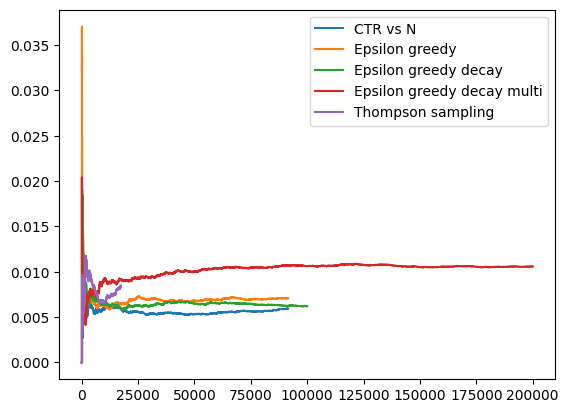

In [34]:
ctr_vs_n_thompson_sampling, i_best_arm = thompson_sampling()
plt.plot(ctr_vs_n, label="CTR vs N")
plt.plot(ctr_vs_n_greedy, label="Epsilon greedy")
plt.plot(ctr_vs_n_greedy_decay, label="Epsilon greedy decay")
plt.plot(ctr_vs_n_greedy_decay_multi, label="Epsilon greedy decay multi")
plt.plot(ctr_vs_n_thompson_sampling, label="Thompson sampling")
plt.legend();

In [35]:
i_best_arm

array([3])